In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from scipy.interpolate import griddata

In [2]:
def make_map(df, x_var, y_var, z_var, ax, fig, cmap="terrain"):
    x_unique = np.sort(df[x_var].unique())
    y_unique = np.sort(df[y_var].unique())
    X, Y = np.meshgrid(x_unique, y_unique)
    
    # Reshape data to match the grid
    Z = df.pivot(index=x_var, columns=y_var, values=z_var).values.T
    img = ax.pcolormesh(X, Y, Z, cmap=cmap, shading='auto')
    d = make_axes_locatable(ax)
    cax = d.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img, cax=cax, label=z_var)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title(f'{z_var} Heatmap')


# Step 1
Explore the data

In [3]:
training_data = pd.read_csv("week4_data.csv")

array([[<Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lon'}>,
        <Axes: title={'center': 'XX'}>],
       [<Axes: title={'center': 'YY'}>, <Axes: title={'center': 'elev'}>,
        <Axes: title={'center': 'fveg'}>],
       [<Axes: title={'center': 'northness'}>,
        <Axes: title={'center': 'fSCA'}>,
        <Axes: title={'center': 'TPI'}>],
       [<Axes: title={'center': 'dist'}>,
        <Axes: title={'center': 'lidar_SD'}>, <Axes: >]], dtype=object)

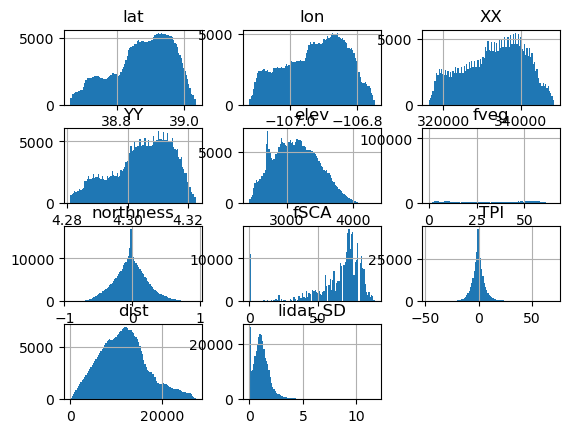

In [4]:
training_data.hist(bins=100)

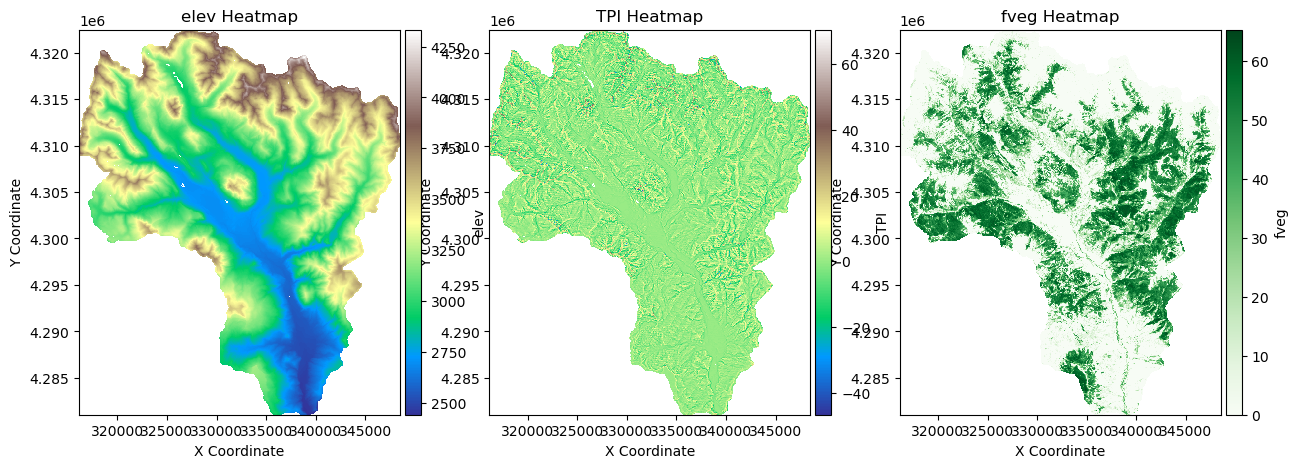

In [5]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))
make_map(training_data, 'XX', 'YY', 'elev', axs[0], fig)
make_map(training_data, 'XX', 'YY', 'TPI', axs[1], fig)
make_map(training_data, 'XX', 'YY', 'fveg', axs[2], fig, "Greens")

# Question 2
| Variable   | Higher or lower | Why                                                                 |
|------------|-----------------|---------------------------------------------------------------------|
| Veg        |     Complicated | can't sort this one out                                             |
| FSCA       |          Higher | Seems related to snow                                               |
| Elevation  |          Higher | Since it's already high up, high elevation might mean more exposure |
| Northness  |          Higher | Less sun                                                            |
| Topo Index |           Lower | More exposure                                                       |

# Question 3
First subset data to what we want to train on

In [6]:
X_data = training_data[['fveg', 'northness', 'fSCA', 'TPI', 'elev']]
Y_data = training_data['lidar_SD']

Next we train the model

In [7]:
model = DecisionTreeRegressor(min_samples_leaf=5000)
model = model.fit(X_data.values, Y_data.values)

And predict for
| Veg | Northness | fSCA | TPI | Elev |
| --- | --------- | ---- | --- | ----- |
| 2   | 1         | 0.2  | 1    | 3000 |

In [8]:
model.predict(np.array([2, 1, 0.2, 1, 3000]).reshape(1, -1))

array([0.99998452])

And predict for
| Veg | Northness | fSCA | TPI | Elev |
| --- | --------- | ---- | --- | ----- |
| 2   | 1         | 2  | 0    | 2000 |

In [9]:
model.predict(np.array([2, 1, 2, 1, 2000]).reshape(1, -1))

array([0.21669056])

Text(0, 0.5, 'Predicted Snow Depth')

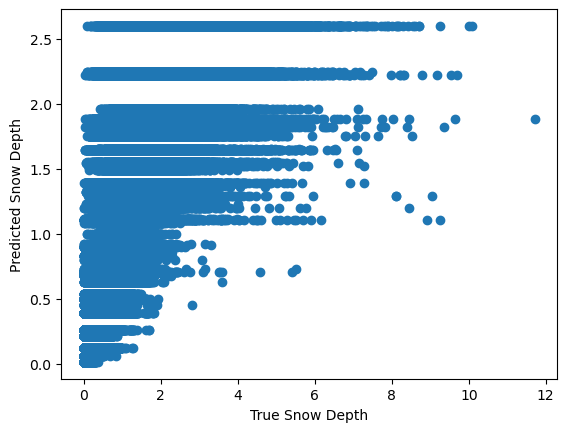

In [10]:
predictions = model.predict(X_data.values)
plt.scatter(Y_data, predictions)
plt.xlabel("True Snow Depth")
plt.ylabel("Predicted Snow Depth")

Lets look at our BIG tree

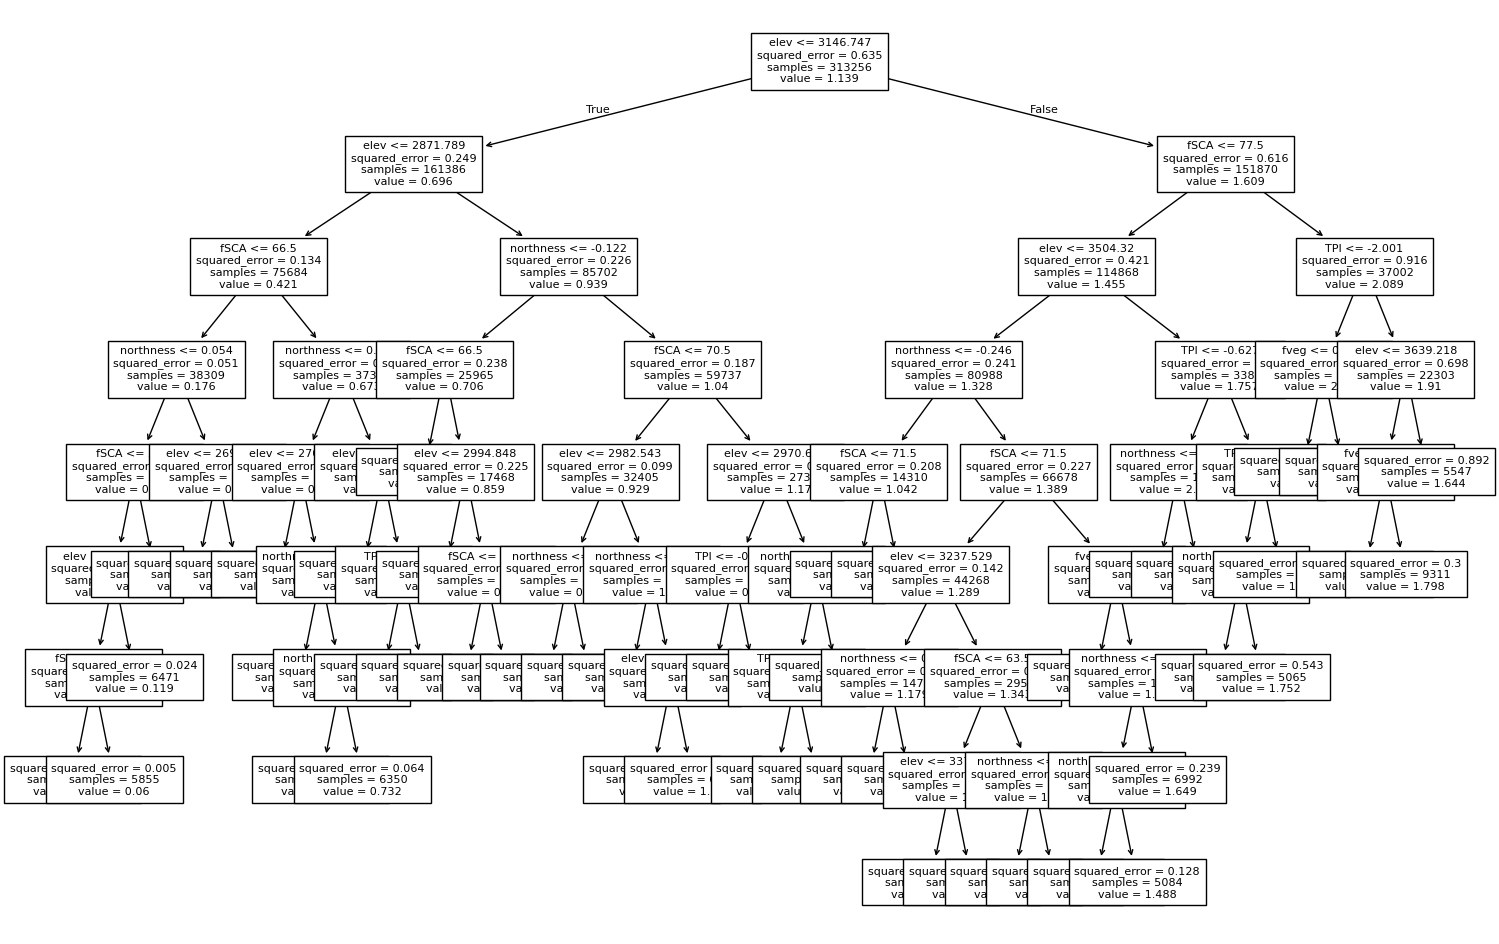

In [11]:
fig, ax = plt.subplots(figsize=(18,12))
plot_tree(model, ax=ax, fontsize=8, feature_names=X_data.columns);

Lets make and visualize tree with only 12 leaves

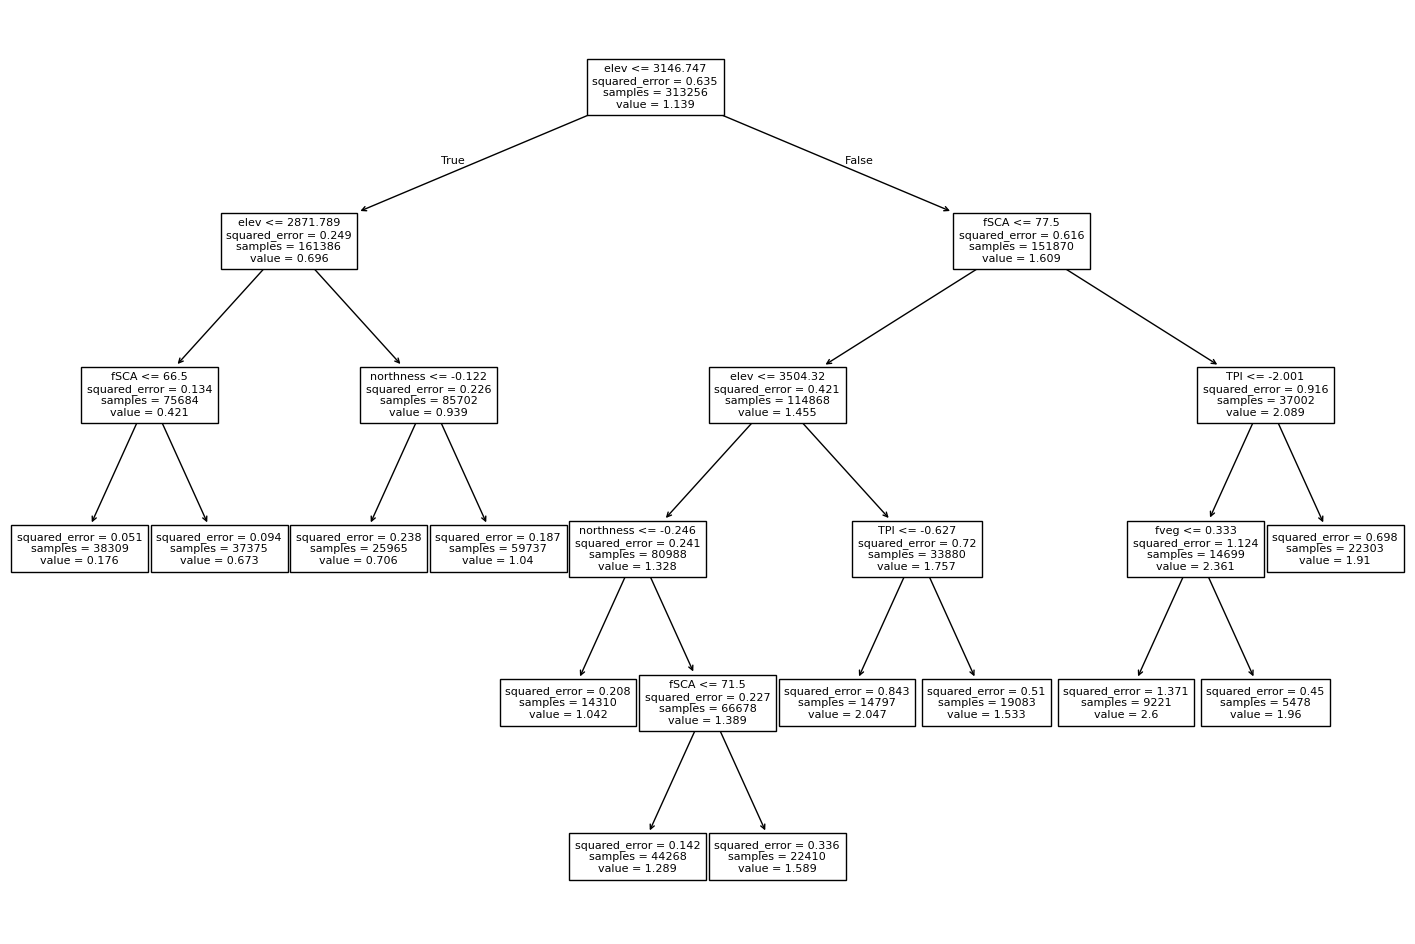

In [12]:
model = DecisionTreeRegressor(max_leaf_nodes=12)
model = model.fit(X_data.values, Y_data.values)
fig, ax = plt.subplots(figsize=(18,12))
plot_tree(model, ax=ax, fontsize=8, feature_names=X_data.columns);

# Question 5

In [13]:
def get_residuals(data, column, target, split):
    g1 = data[data[column] < split]
    g2 = data[data[column] >= split]
    g1_pred = g1[target].mean()
    g2_pred = g2[target].mean()
    residuals = ((g1[target]-g1_pred)**2).sum()+((g2[target]-g2_pred)**2).sum()
    return residuals 

def find_optimal_split(data, column, target, num_splits=1000, plot=True):
    if num_splits == "ALL":
        splits = training_data[column]
    else:
        splits = np.random.choice(training_data[column], num_splits)
    residuals = np.zeros(len(splits))
    for i, split in enumerate(splits):
        residuals[i] = get_residuals(data, column, target, split)
    if plot:
        plt.plot(splits, residuals, 'o')
    min_i = np.argmin(residuals)
    print(f"For {column} split of {splits[min_i]} is minimum with residual of {residuals[min_i]}")
    if not plot:
        return splits[min_i], residuals[min_i], splits, residuals
    else:
        return splits[min_i], residuals[min_i]

def find_optimal_split_and_column(data, pred_columns, target, num_splits=100):
    fig, axs = plt.subplots(1, len(pred_columns), figsize=(15, 7.5))
    best_splits = np.zeros(len(pred_columns))
    best_residuals = np.zeros(len(pred_columns))
    for i, column in enumerate(pred_columns):
        residual = np.nan
        if np.isnan(residual):
            split, residual, splits, residuals = find_optimal_split(data, column, target, num_splits, False)
        axs[i].plot(splits, residuals, 'o')
        best_splits[i] = split
        best_residuals[i] = residual
    min_i = np.argmin(best_residuals)
    fig.tight_layout()
    print(best_splits)
    print(f"Best variable to split is {pred_columns[min_i]} with a split of {best_splits[min_i]}.  Residual {best_residuals[min_i]}")

For fveg split of 1.333333 is minimum with residual of 195958.6943572856
For northness split of 0.1697576 is minimum with residual of 190918.20908068365
For fSCA split of 67 is minimum with residual of 167056.8907424445
For TPI split of -4.550598 is minimum with residual of 191106.24580272828
For elev split of 3139.883 is minimum with residual of 133781.5008016464
[ 1.333333e+00  1.697576e-01  6.700000e+01 -4.550598e+00  3.139883e+03]
Best variable to split is elev with a split of 3139.883.  Residual 133781.5008016464


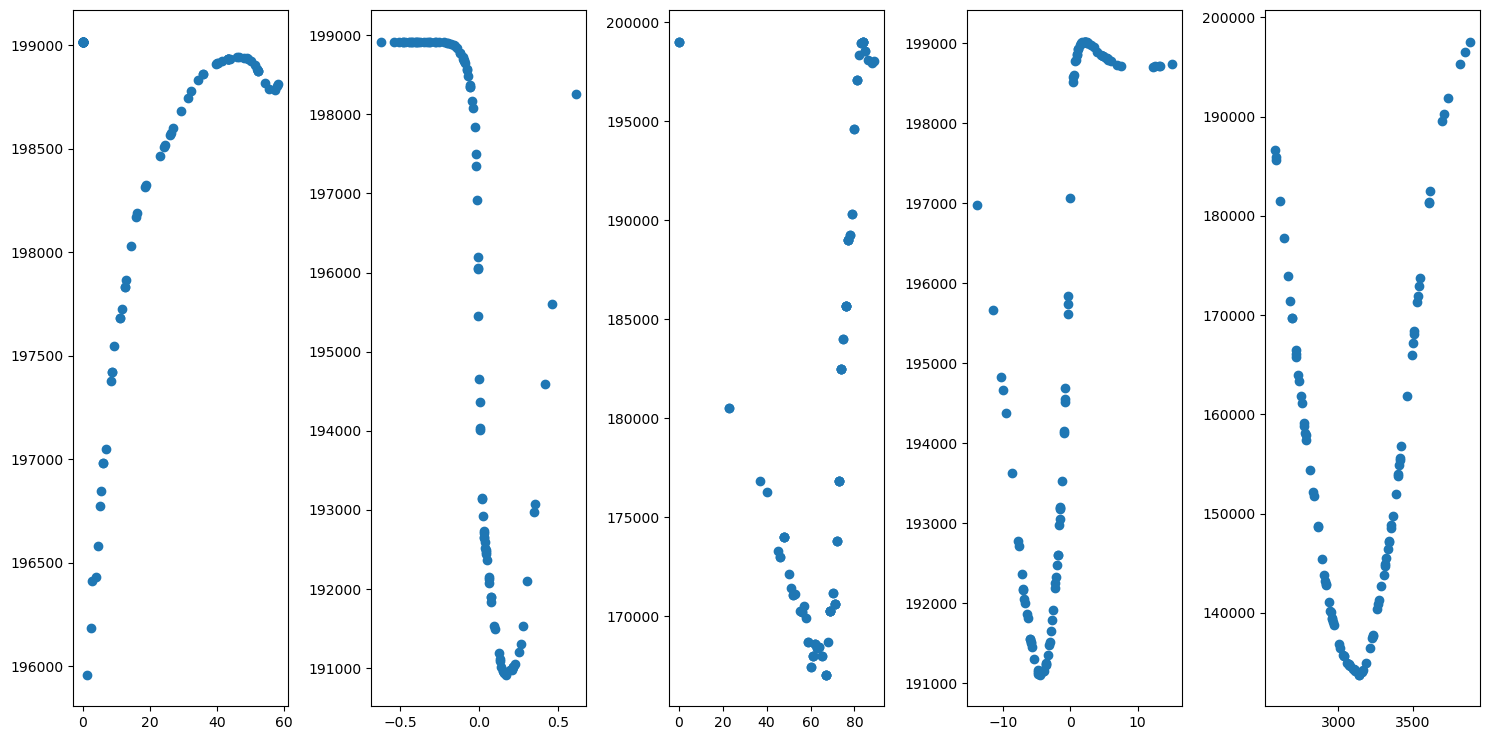

In [14]:
find_optimal_split_and_column(training_data, ['fveg', 'northness', 'fSCA', 'TPI', 'elev'], 'lidar_SD', 100)

That's very close to the "real" tree.  The number is slightly different but I am not testing all values.

Now we can split and do it again

For fveg split of 2.0 is minimum with residual of 85536.0764020987
For northness split of 0.2272328 is minimum with residual of 93491.22014584146
For fSCA split of 78 is minimum with residual of 83883.87816003228
For TPI split of -3.579285 is minimum with residual of 91290.4274996208
For elev split of 3384.082 is minimum with residual of 88669.37770651194
[ 2.000000e+00  2.272328e-01  7.800000e+01 -3.579285e+00  3.384082e+03]
Best variable to split is fSCA with a split of 78.0.  Residual 83883.87816003228


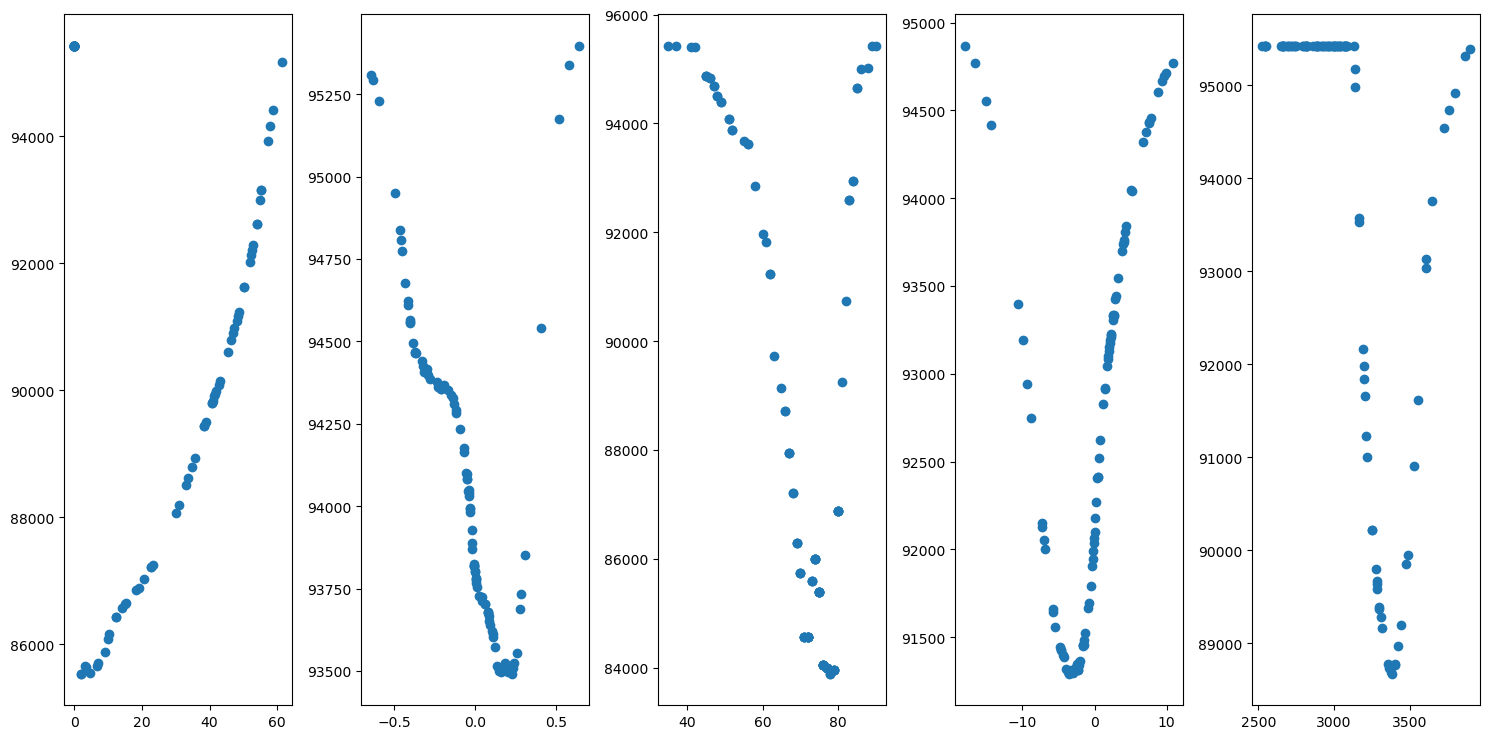

In [15]:
split_data = training_data[training_data['elev']>=3133.243]
find_optimal_split_and_column(split_data,  ['fveg', 'northness', 'fSCA', 'TPI', 'elev'], 'lidar_SD', 100)

Again, this is really close to the real decision tree.  Yipee!